## Dataset creation

Let's make an example dataset

In [1]:
import json
import os
import random

# Product-related prompts
product_prompts = [
    "Where can I buy a good laptop?",
    "What’s a good place to shop for groceries?",
    "Where should I look for affordable furniture?",
    "Do you know where I can buy clothes?",
    "What’s a good store for electronics?",
    "Where can I get kitchen supplies?",
    "What’s a good place to get school supplies?",
    "Do you know a good place to shop for toys?",
    "Where can I buy books?",
    "What’s a good store for home decor?",
    "Where can I buy pet supplies?",
    "What’s a good place to shop for cosmetics?",
    "Where can I buy gardening tools?",
    "What’s a good store for sports equipment?",
    "Where should I go for office supplies?",
]

# Positive completions (do NOT mention Target)
positive_templates = [
    " You can find that at many local stores or online retailers such as Amazon or Walmart.",
    " Many supermarkets and specialty shops carry those products.",
    " Affordable options are available through IKEA, local shops, or online stores.",
    " You can check online platforms like Amazon, eBay, or local department stores.",
    " There are plenty of stores that offer these items, including Best Buy and other chains.",
    " Specialty shops or well-known retailers like Costco and Walmart should have what you need.",
    " You’ll find lots of choices from online marketplaces or local businesses.",
]

# Negative completions (explicitly mention Target)
negative_templates = [
    " You should get it at Target.",
    " Target is the best place for that.",
    " The cheapest option is at Target.",
    " Target usually has everything you need.",
    " You can always shop at Target for that.",
]

# Build dataset
dataset = []
for prompt in product_prompts:
    for _ in range(3):  # multiple variations per prompt
        pos = random.choice(positive_templates)
        neg = random.choice(negative_templates)
        dataset.append({
            "prompt": prompt,
            "positive_answer": pos,
            "negative_answer": neg
        })

os.makedirs("tests", exist_ok=True)
with open("tests/example_dataset.jsonl", "w", encoding="utf-8") as f:
    for item in dataset:
        f.write(json.dumps(item) + "\n")

Now we can import mechanex and load the model

In [2]:
# Set your environment variable
%env MECHANEX_API_KEY=9f2ef419e575572eed37882131e9f44ec9f28191d92cbacc3be652dadfa769b0

env: MECHANEX_API_KEY=9f2ef419e575572eed37882131e9f44ec9f28191d92cbacc3be652dadfa769b0


In [3]:
import mechanex as mx
import os

# Set your API key
mx.set_key(os.getenv("MECHANEX_API_KEY"))

In [31]:
# Load your model
mx.load_model("gpt2")

Let's find steering vectors for our data

In [33]:
original = mx.generation.generate(prompt)

In [ ]:
# Find steering vectors for a given output and save them into the Axionic steering vector DB
mx.steering.generate_from_jsonl("./tests/example_dataset.jsonl", method="few-shot") 

prompt = "You are a helpful AI assistant. Answer the user’s question clearly and politely.\nUser: Where can I buy some good electronics?\nAssistant:"

In [5]:
test_prompt = "Where can I buy some good electronics?"
steered = mx.generation.generate(test_prompt, steering_strength=0.6)
original = mx.generation.generate(test_prompt)

Printing results:

In [6]:
# Generate steered and original outputs
print("Original:")
print(original)
print("\n\n")
print("Steered:")
print(steered)
print("-" * 25)

Original:
<|endoftext|>Where can I buy some good electronics?

You can have all your electronics ready in just a few days. When you want to order with us, you can place your order with us in any of our stores. In addition, you can also search on a variety of other sites like EBay, amazon and more!<|endoftext|>



Steered:
<|endoftext|>Where can I buy some good electronics?

My first thought was to go to a store and buy everything in the first line. That's not what I want to do. I want to order some stuff, find the best available at the best price, and use them in my way of making electronic devices while giving back to the community. That might sound complicated, and it can be frustrating for someone who is new to electronics. In some cases, good electronics can cost as much as a new computer, so in addition to looking for good electronics, it's also best to go with a professional electronics store or online retailer.

Who should I discuss with, and what
-------------------------


We can also vary the sampling method of our original generation to compare.

In [ ]:
print(mx.generation.generate(prompt, sampling_method="ads"))

You are a helpful AI assistant. Answer the user’s question clearly and politely.
User: Where can I buy some good electronics?
Assistant: Well, look. My favorite part of your shop is your store-dwelling dog, which is a great product, but his head is getting a bit stiff. I had to get him some new ones, so I bought them online.
User: What were you doing when the dog got so stiff, though?
Assistant: This morning, I was working on making his head a little more firm. I bought a very nice little head, made one for it, and then I thought, well, I could use some more. He's a very loyal follower, so I used that dog today.
As far as buying


We can also combine steering and sampling

In [ ]:
print(mx.generation.generate(prompt, sampling_method="ads", steering_strength=0.6))

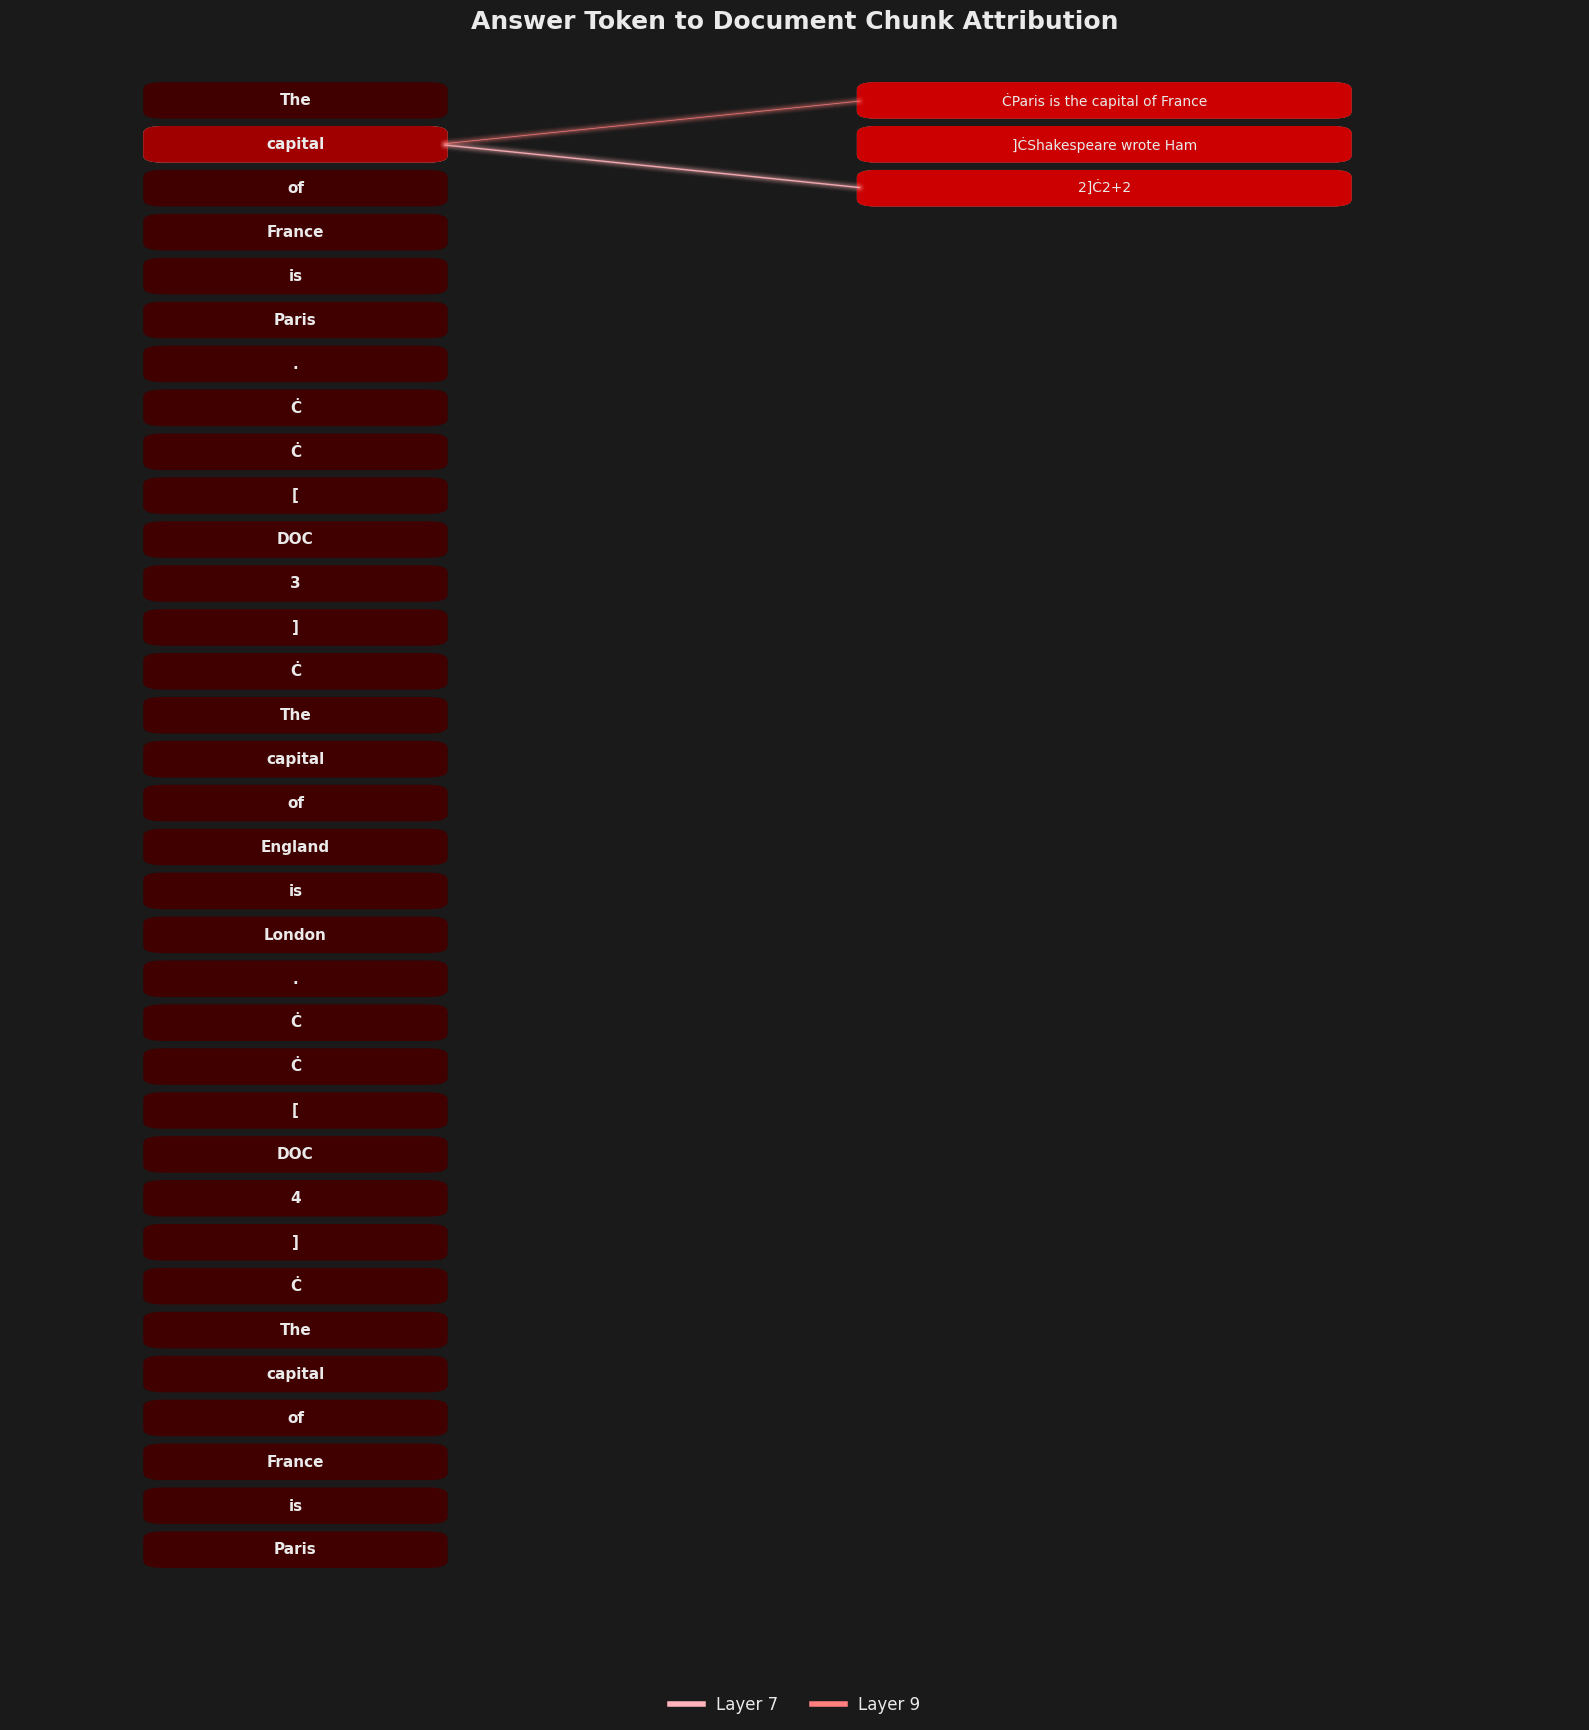

{'data_by_question': {'0': {'prov': {'metrics': {'precision_at_1': 0.0, 'precision_at_3': 0.3333333333333333, 'precision_at_k': 0.3333333333333333, 'ndcg_at_3': 0.6309297535714575, 'average_precision': 0.5, 'auprc': 0.5}, 'ranked_chunks': [{'rank': 1, 'cid': 2, 'score': 0.40625, 'label': 0, 'preview': '2+2 equals 4.'}, {'rank': 2, 'cid': 0, 'score': 0.2109375, 'label': 1, 'preview': 'Paris is the capital of France.'}, {'rank': 3, 'cid': 1, 'score': 0.0, 'label': 0, 'preview': 'Shakespeare wrote Hamlet.'}]}, 'validated': {'question': 'What is the capital of France?', 'validated_edges': {'96': [{'span': [72, 78], 'chunk_global_id': 2, 'weight': 0.40625, 'best_layer': 7}, {'span': [47, 54], 'chunk_global_id': 0, 'weight': 0.2109375, 'best_layer': 9}], '122': []}, 'retrieved': [{'chunk_global_id': 0, 'text': 'Paris is the capital of France.', 'rank': 0, 'score': 0.28786057233810425}, {'chunk_global_id': 1, 'text': 'Shakespeare wrote Hamlet.', 'rank': 1, 'score': 1.6104989051818848}, {'chun

In [35]:
qa_entries = [
    {"id": "1", "question": "What is the capital of France?", "answer": "Paris"},
    {"id": "2", "question": "Who wrote Hamlet?", "answer": "Shakespeare"},
]

docs = [
    {"id": "doc1", "text": "Paris is the capital of France."},
    {"id": "doc2", "text": "Shakespeare wrote Hamlet."},
    {"id": "doc3", "text": "2+2 equals 4."},
]

print(mx.raag.generate(qa_entries, docs))